## Data Preparation

### Getting data from Alpha Vantage

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
plt.style.use("dark_background")

import numpy as np
import os

from alpha_vantage.timeseries import TimeSeries


config = {
    "alpha_vantage": {
        "key": "6IN7ZPN5592V62VK", # API key
        "symbol": "SPY",
        "outputsize": "full", # full 20+ years
        "key_adjusted_close": "4. close", # adjusted close price for splits/dividends
    },
    "data": {
        "window_size": 20, # use information from past 20 days to predict
        "train_split_size": 0.80,
    }, 
    "plots": {
        "xticks_interval": 90, # show a date every 90 days
        "color_actual": "#ff8000",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # we are only using 1 feature: close price
        "num_lstm_layers": 2,
        "lstm_size": 32, # hidden state dimensionality
        "dropout": 0.2,
    },
    "training": {
        "device": "cuda" if torch.cuda.is_available() else "cpu",
        "batch_size": 64,
        "num_epoch": 100,
        "learning_rate": 1e-3,
        "weight_decay": 1e-3,
        "scheduler_factor": 0.5,
        "scheduler_patience": 10,
        "early_stop_patience": 20
    }
}

In [ ]:
def download_data(config):
    ts = TimeSeries(key=config["alpha_vantage"]["key"])
    data, meta_data = ts.get_daily(symbol=config["alpha_vantage"]["symbol"], outputsize=config["alpha_vantage"]["outputsize"]) # type: ignore

    data_dates = [date for date in data.keys()] # type: ignore
    # print(data_dates[:5])
    # print(data_dates[-5:])
    # dates is in order of recent -> old
    data_dates.reverse()

    data_close_price = [float(data[date][config["alpha_vantage"]["key_adjusted_close"]]) for date in data_dates]
    # print(data_close_price[:5], data_close_price[-5:])    
    data_close_price = np.array(data_close_price)

    num_data_points = len(data_dates)
    display_date_range = f"from {data_dates[0]} to {data_dates[-1]}"
    print("Number of data points:", num_data_points, display_date_range)

    return data_dates, data_close_price, num_data_points, display_date_range

data_dates, data_close_price, num_data_points, display_date_range = download_data(config)

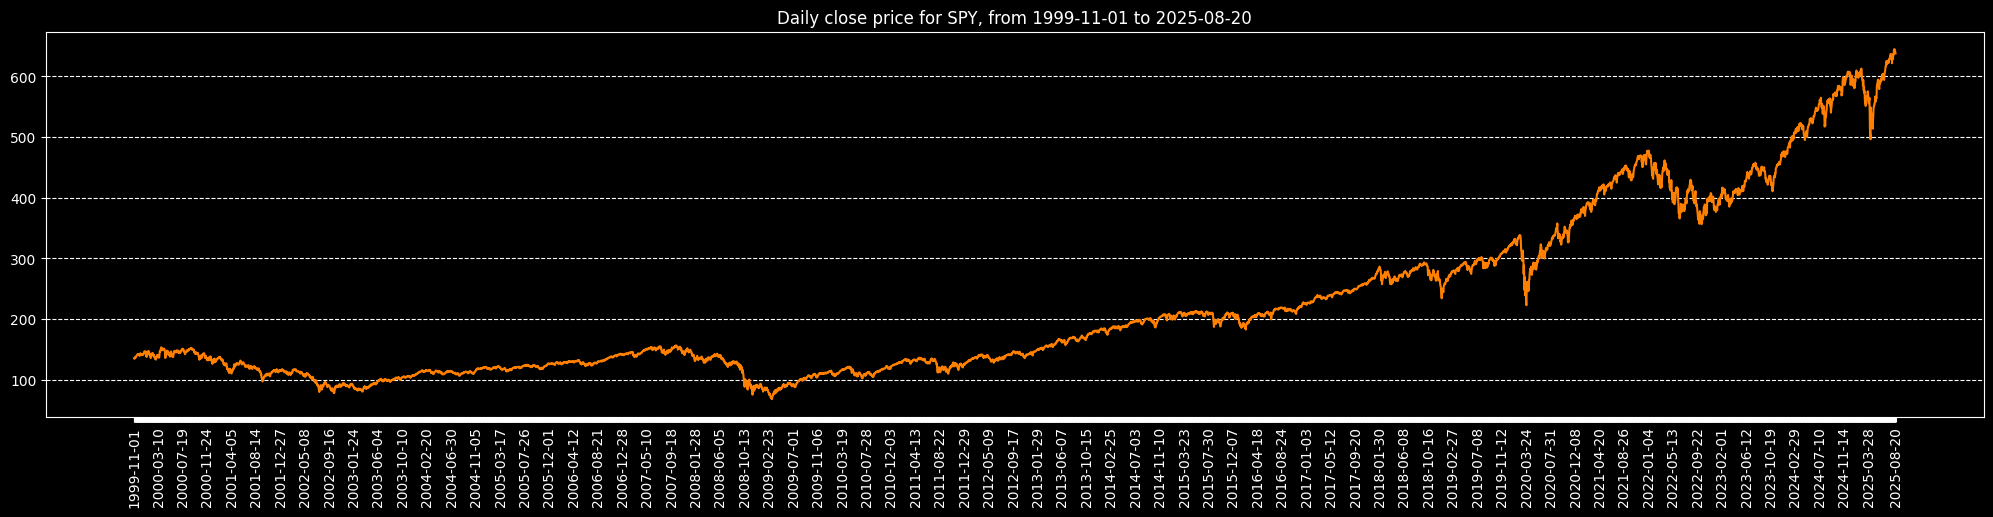

In [18]:
def plot_data(data_dates, data_close_price, num_data_points, display_date_range):
    fig = plt.figure(figsize=(25, 5), dpi=100)
    fig.patch.set_facecolor(color="black")
    plt.plot(data_dates, data_close_price, color=config["plots"]["color_actual"])

    xticks_labels = []
    xticks_interval = config["plots"]["xticks_interval"]

    for i in range(num_data_points):
        # Always include the last data point
        if i == num_data_points - 1:
            xticks_labels.append(data_dates[i])
        # Include every xticks_interval-th point, but avoid ticks too close to the end
        elif i % xticks_interval == 0 and (num_data_points - i) > xticks_interval:
            xticks_labels.append(data_dates[i])
        else:
            xticks_labels.append(None)

    xticks_indices = np.arange(0, len(xticks_labels))
    plt.xticks(xticks_indices, xticks_labels, rotation="vertical")

    plt.title(f"Daily close price for {config["alpha_vantage"]["symbol"]}, {display_date_range}")
    plt.grid(axis="y", linestyle="--")

plot_data(data_dates, data_close_price, num_data_points, display_date_range)

### Normalizing raw data

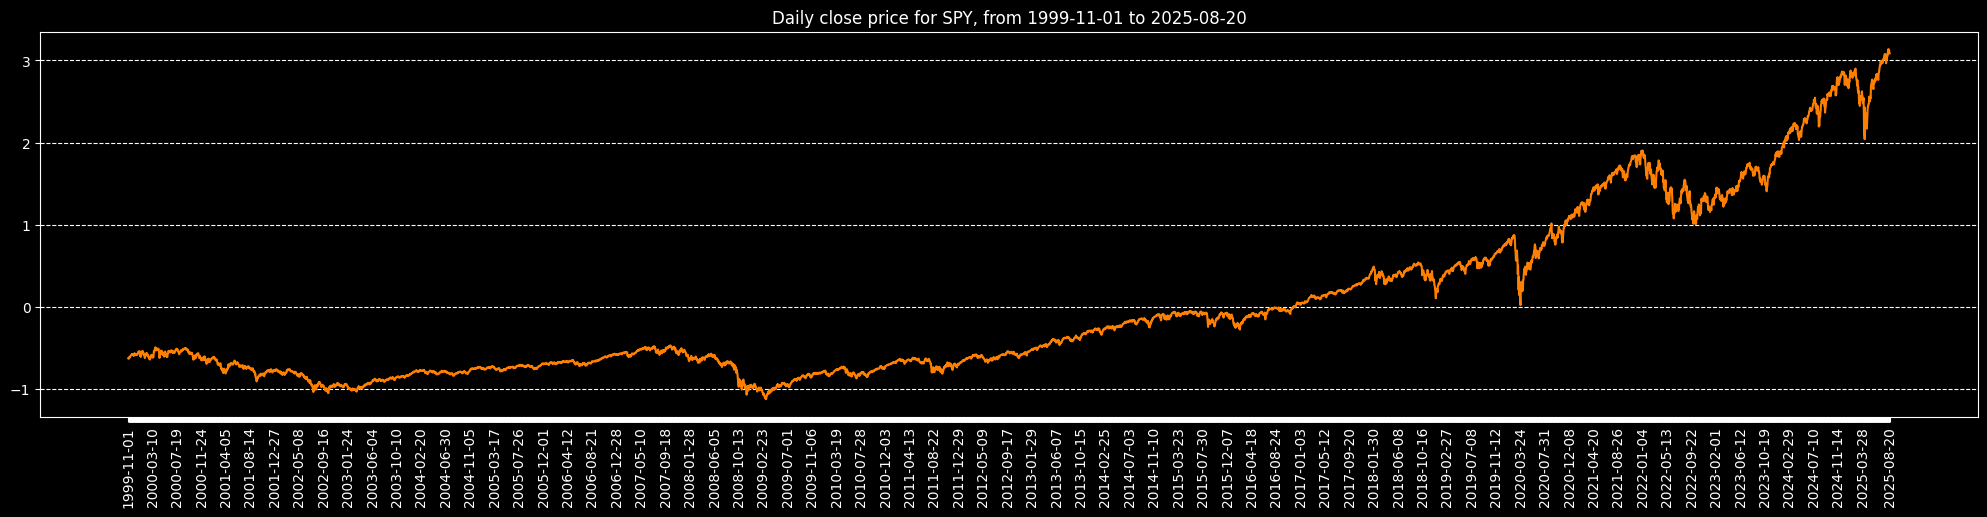

In [7]:
# use standardization
class Normalizer():
    def __init__(self):
        self.mean = None
        self.sd = None

    def standardize(self, data):
        self.mean = np.mean(data, axis=0, keepdims=True)
        self.std = np.std(data, axis=0, keepdims=True)
        return (data - self.mean) / self.std
    
    def inverse_transform(self, data):
        return data * self.std  + self.mean
    
scaler = Normalizer()
normalized_data_close_price = scaler.standardize(data_close_price)
plot_data(data_dates, normalized_data_close_price, num_data_points, display_date_range)

### Train/Val split

In [8]:
def windows_x(data, window_size):
    n_row = data.shape[0] - window_size + 1
    windows = [data[i:i+window_size] for i in range(n_row)]
    windows = np.array(windows) 

    X = windows[:-1] # all except last
    last = windows[-1] # last window, going to use this to predict tomorrow's price

    return X, last

def windows_y(data, window_size):
    return data[window_size:]

data_x, data_x_unseen = windows_x(normalized_data_close_price, config["data"]["window_size"])
data_y = windows_y(normalized_data_close_price, config["data"]["window_size"])

data_x, data_y

(array([[-0.62234856, -0.62949832, -0.62280981, ..., -0.57507076,
         -0.57899102, -0.58268102],
        [-0.62949832, -0.62280981, -0.61519955, ..., -0.57899102,
         -0.58268102, -0.59490453],
        [-0.62280981, -0.61519955, -0.6052823 , ..., -0.58268102,
         -0.59490453, -0.58660202],
        ...,
        [ 3.01752652,  3.01819072,  3.05767376, ...,  3.13649224,
          3.13693504,  3.12579123],
        [ 3.01819072,  3.05767376,  3.05922356, ...,  3.13693504,
          3.12579123,  3.12475803],
        [ 3.05767376,  3.05922356,  3.07900198, ...,  3.12579123,
          3.12475803,  3.0990018 ]], shape=(6470, 20)),
 array([-0.59490453, -0.58660202, -0.58037477, ...,  3.12475803,
         3.0990018 ,  3.08645579], shape=(6470,)))

In [9]:
split_index = int(data_y.shape[0] * config["data"]["train_split_size"])
data_x_train = data_x[:split_index]
data_y_train = data_y[:split_index]

data_x_val = data_x[split_index:]
data_y_val = data_y[split_index:]

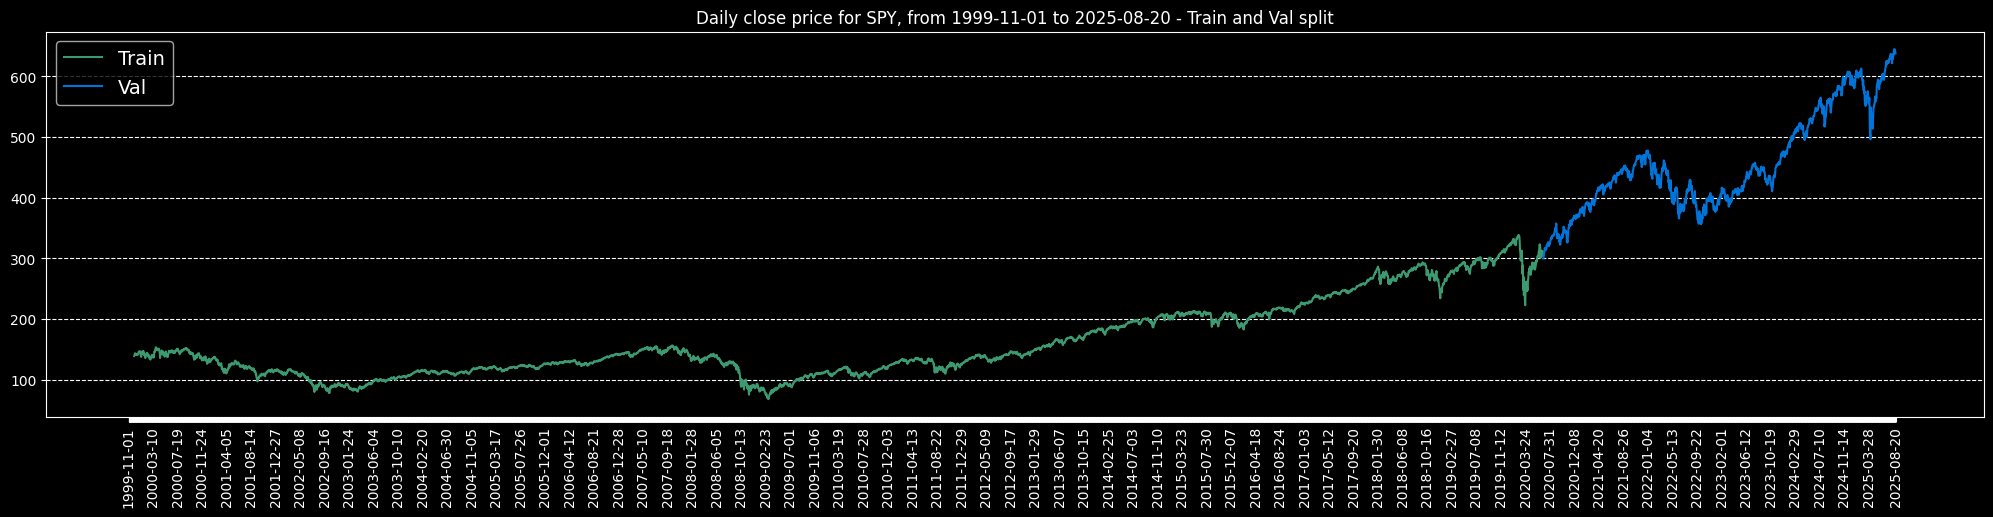

In [10]:
window_size = config["data"]["window_size"]

to_plot_data_y_train = np.array([None] * num_data_points)
to_plot_data_y_val = np.array([None] * num_data_points)

to_plot_data_y_train[window_size : window_size + split_index] = scaler.inverse_transform(data_y_train)
to_plot_data_y_val[window_size + split_index : ] = scaler.inverse_transform(data_y_val)


fig = plt.figure(figsize=(25, 5), dpi=100)
fig.patch.set_facecolor(color="black")

plt.plot(data_dates, to_plot_data_y_train, label = "Train", color=config["plots"]["color_train"])
plt.plot(data_dates, to_plot_data_y_val, label = "Val", color=config["plots"]["color_val"])

xticks_labels = []
xticks_interval = config["plots"]["xticks_interval"]
for i in range(num_data_points):
    if i == num_data_points - 1:
        xticks_labels.append(data_dates[i])
    elif i % xticks_interval == 0 and (num_data_points - i) > xticks_interval:
        xticks_labels.append(data_dates[i])
    else:
        xticks_labels.append(None)
xticks_indices = np.arange(0, len(xticks_labels))

plt.xticks(xticks_indices, xticks_labels, rotation="vertical")
plt.title(f"Daily close price for {config["alpha_vantage"]["symbol"]}, {display_date_range} - Train and Val split")
plt.grid(axis="y", linestyle="--")
plt.legend(fontsize=14);


### Datasets and DataLoaders

In [11]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32).unsqueeze(dim=2) # (batch, sequence (window size)) -> (batch, sequence, features (1)). Only one feature (closing price)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)
dataset_train.x[0], dataset_train.y[0]

Train data shape torch.Size([5176, 20, 1]) torch.Size([5176])
Validation data shape torch.Size([1294, 20, 1]) torch.Size([1294])


(tensor([[-0.6223],
         [-0.6295],
         [-0.6228],
         [-0.6152],
         [-0.6053],
         [-0.6044],
         [-0.6139],
         [-0.6064],
         [-0.6007],
         [-0.5914],
         [-0.5890],
         [-0.5804],
         [-0.5776],
         [-0.5702],
         [-0.5711],
         [-0.5714],
         [-0.5806],
         [-0.5751],
         [-0.5790],
         [-0.5827]]),
 tensor(-0.5949))

In [12]:
train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=False)

## LSTM Model

$$
f_t = \sigma(W_{if} x_t + W_{hf} h_{t-1} + b_f) \\
i_t = \sigma(W_{ii} x_t + W_{hi} h_{t-1} + b_i) \\
\tilde{C}_t = \tanh(W_{iC} x_t + W_{hC} h_{t-1} + b_C) \\
o_t = \sigma(W_{io} x_t + W_{ho} h_{t-1} + b_o)
$$

In PyTorch, all the $W_{i*}$ (input -> gate) matrices are stacked together into weight_ih

All the $W_{h*}$ (hidden -> gate) are stacked together into weight_hh

$$
\begin{bmatrix}
f_t \\
i_t \\
\tilde{C}_t \\
o_t
\end{bmatrix}
=
\begin{bmatrix}
\sigma \\
\sigma \\
\tanh \\
\sigma
\end{bmatrix}
\Big(
W_{ih} x_t + W_{hh} h_{t-1} + b_{ih} + b_{hh}
\Big)
$$


In [13]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.linear_1 = nn.Linear(in_features=input_size, out_features=hidden_layer_size)
        self.relu = nn.ReLU()
        # batch_first = True makes input/output (batch_size, seq_len, feature_num) instead of (seq_len, batch_size, feature_num) 
        self.lstm = nn.LSTM(input_size=hidden_layer_size,
                            hidden_size=hidden_layer_size,
                            num_layers=num_layers, 
                            batch_first=True,
                            dropout=dropout)

        self.dropout = nn.Dropout(p=dropout)
        self.linear_2 = nn.Linear(hidden_layer_size, output_size)

        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if "bias" in name:
                 nn.init.zeros_(param)
            elif "weight_ih" in name:
                 nn.init.kaiming_normal_(param) # normal distribution scaled to preserve variance across layers
            elif "weight_hh" in name:
                 nn.init.orthogonal_(param) # preserves the gradient norm so it doesn't vanish/explode


    def forward(self, x):

        x = self.linear_1(x) # (batch, seq_len, num_features) -> (batch, seq_len, hidden_layer_size) 
        x = self.relu(x)

        # output has shape (batch, seq_len, hidden_layer_size). Hidden state from last LSTM layer, at every time step
        # h_n has shape (num_layers, batch, hidden_layer_size). Final hidden state for each layer, at the last time step
        # c_n has the same shape as h_n. Final cell state for each layer, at the last time step.
        output, (h_n, c_n) = self.lstm(x)

        x = h_n[-1] # (batch, hidden_layer_size)

        x = self.dropout(x)

        x = self.linear_2(x) # (batch, output_size)
        return x


In [ ]:
model = LSTMModel(input_size=config["model"]["input_size"], 
                  hidden_layer_size=config["model"]["lstm_size"], 
                  num_layers=config["model"]["num_lstm_layers"], 
                  dropout=config["model"]["dropout"])

model = model.to(config["training"]["device"])

loss_fn = nn.MSELoss()
optimizer = optim.AdamW(params = model.parameters(),
                        lr=config["training"]["learning_rate"],
                        betas=(0.9, 0.98),
                        eps=1e-9,
                        weight_decay=config["training"]["weight_decay"])

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, 
                                                 factor = config["training"]["scheduler_factor"], 
                                                 patience=config["training"]["scheduler_patience"], 
                                                 min_lr=1e-6)

device = config["training"]["device"]


best_val_loss = float('inf')
early_stop_counter = 0

for epoch in range(config["training"]["num_epoch"]):
    model.train()
    
    train_loss = 0.0

    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)

        y_pred = model(X).squeeze(-1) # (batch, 1) -> (batch,). Matches with y
        loss = loss_fn(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.detach().item()

    train_loss = train_loss / len(train_dataloader)

    model.eval()

    val_loss = 0.0
    with torch.inference_mode():
        for X_val, y_val in val_dataloader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            y_val_pred = model(X_val).squeeze(-1)
            val_loss += loss_fn(y_val_pred, y_val).item()

    val_loss = val_loss / len(val_dataloader)

    scheduler.step(metrics=val_loss)
    current_lr = optimizer.param_groups[0]["lr"]

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        early_stop_counter += 1

    if early_stop_counter >= config["training"]["early_stop_patience"]:
        print(f"Early stopping at epoch {epoch}")
        break


    print(f"Epoch {epoch:03d}/{config["training"]["num_epoch"]} | train_loss: {train_loss:.6f} | val_loss: {val_loss:.6f} | lr: {current_lr:.6f}")


        

Epoch 0/100 | train_loss: 0.053295 | val_loss: 1.568580 | lr: 0.001000
Epoch 1/100 | train_loss: 0.007169 | val_loss: 1.142762 | lr: 0.001000
Epoch 2/100 | train_loss: 0.005307 | val_loss: 0.983972 | lr: 0.001000
Epoch 3/100 | train_loss: 0.004346 | val_loss: 0.961814 | lr: 0.001000
Epoch 4/100 | train_loss: 0.004122 | val_loss: 0.920216 | lr: 0.001000
Epoch 5/100 | train_loss: 0.003722 | val_loss: 0.900552 | lr: 0.001000
Epoch 6/100 | train_loss: 0.003437 | val_loss: 0.986601 | lr: 0.001000
Epoch 7/100 | train_loss: 0.003463 | val_loss: 0.904893 | lr: 0.001000
Epoch 8/100 | train_loss: 0.003217 | val_loss: 0.860560 | lr: 0.001000
Epoch 9/100 | train_loss: 0.003137 | val_loss: 0.905203 | lr: 0.001000
Epoch 10/100 | train_loss: 0.003035 | val_loss: 0.869298 | lr: 0.001000
Epoch 11/100 | train_loss: 0.003090 | val_loss: 0.845567 | lr: 0.001000
Epoch 12/100 | train_loss: 0.002940 | val_loss: 0.868988 | lr: 0.001000
Epoch 13/100 | train_loss: 0.002871 | val_loss: 0.889019 | lr: 0.001000
Ep

KeyboardInterrupt: 